# Imports

In [1]:
!git clone https://huggingface.co/datasets/Djulo/Wider_FaceSegLite data/

Streaming output truncated to the last 5000 lines.
	images/44--Aerobics/44_Aerobics_Aerobics_44_317.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_320.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_321.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_329.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_332.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_337.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_339.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_34.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_342.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_343.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_344.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_346.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_35.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_357.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_360.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_364.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_365.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_367.j

In [2]:
!pip install -q segmentation-models-pytorch==0.3.3
!pip install -q pytorch-lightning==1.9.5
!pip install -q torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00


In [3]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from pprint import pprint
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as T

# How to test the model

First, get the pth of the model.

In [4]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.block1 = conv_block(3, 16)
        self.block2 = conv_block(16, 32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64, 128)
        self.block5 = conv_block(128, 256)

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.block6 = conv_block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.block7 = conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.block8 = conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.block9 = conv_block(32, 16)

        self.output = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        pool1 = F.max_pool2d(block1, 2)
        block2 = self.block2(pool1)
        pool2 = F.max_pool2d(block2, 2)
        block3 = self.block3(pool2)
        pool3 = F.max_pool2d(block3, 2)
        block4 = self.block4(pool3)
        pool4 = F.max_pool2d(block4, 2)
        block5 = self.block5(pool4)

        up6 = self.upconv4(block5)
        concat6 = torch.cat([up6, block4], dim=1)
        block6 = self.block6(concat6)
        up7 = self.upconv3(block6)
        concat7 = torch.cat([up7, block3], dim=1)
        block7 = self.block7(concat7)
        up8 = self.upconv2(block7)
        concat8 = torch.cat([up8, block2], dim=1)
        block8 = self.block8(concat8)
        up9 = self.upconv1(block8)
        concat9 = torch.cat([up9, block1], dim=1)
        block9 = self.block9(concat9)

        out = self.output(block9)

        return out

In [5]:
class FaceModel(pl.LightningModule):

    def __init__(self, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = UNet(num_classes=out_classes)

        # preprocessing parameteres for image
        self.register_buffer("std", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]


        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cpu


In [7]:
! cp /content/drive/MyDrive/deep_nn/unet_model_small_v2.pth .

In [8]:
loaded_model = FaceModel(in_channels=3, out_classes=1)
loaded_model.load_state_dict(torch.load('unet_model_small_v2.pth', map_location=torch.device(device)))
loaded_model.to(device)

print("Model loaded.")

Model loaded.


#### Test on our dataset

In [9]:
def eval_transform(image):
  target_size = (256, 256)
  transforms = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True), T.Resize(target_size, antialias=True)])
  return transforms(image)

In [10]:
file_path = "data/images/10--People-Marching/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_675.jpg"
#image = cv2.imread(file_path)
image = np.array(Image.open(file_path))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = eval_transform(image)

In [11]:
image.size()

torch.Size([3, 256, 256])

In [12]:
with torch.no_grad():
    loaded_model.eval()
    logits = loaded_model(image.to(device))
pr_masks = logits.sigmoid()

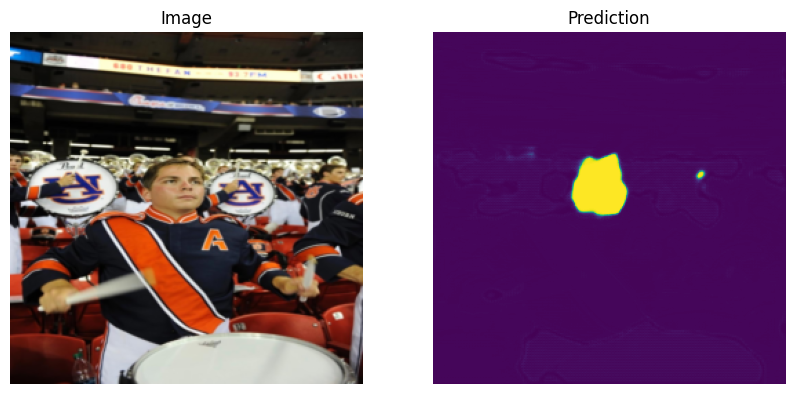

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pr_masks.numpy().squeeze()) # just squeeze classes dim, because we have only one class
plt.title("Prediction")
plt.axis("off")

plt.show()

In [14]:
pr_masks

tensor([[[[0.0243, 0.0280, 0.0264,  ..., 0.0289, 0.0273, 0.0307],
          [0.0299, 0.0273, 0.0270,  ..., 0.0306, 0.0354, 0.0337],
          [0.0286, 0.0280, 0.0237,  ..., 0.0257, 0.0230, 0.0260],
          ...,
          [0.0302, 0.0301, 0.0272,  ..., 0.0264, 0.0270, 0.0245],
          [0.0304, 0.0275, 0.0245,  ..., 0.0307, 0.0303, 0.0249],
          [0.0239, 0.0247, 0.0220,  ..., 0.0203, 0.0226, 0.0263]]]])

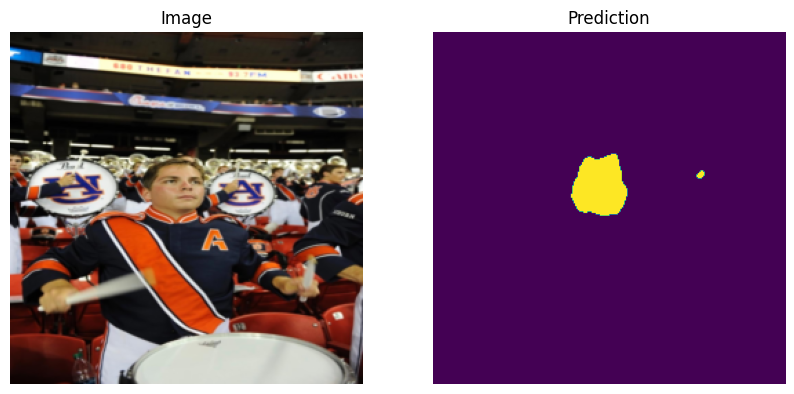

In [15]:
threshold = 0.5  # Set a threshold

pr_masks = pr_masks.numpy().squeeze()
pr_masks = pr_masks > threshold

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pr_masks) # just squeeze classes dim, because we have only one class
plt.title("Prediction")
plt.axis("off")

plt.show()

In [16]:
import torch
from transformers import YolosForObjectDetection, YolosImageProcessor

In [17]:
from PIL import Image

image = Image.open('data/images/10--People-Marching/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_675.jpg')

In [18]:
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)


# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.985 at location [23.81, 541.66, 747.36, 1500.9]
Detected chair with confidence 0.95 at location [18.06, 931.8, 116.64, 1032.75]
Detected chair with confidence 0.944 at location [338.62, 1303.01, 982.34, 1537.42]
Detected chair with confidence 0.967 at location [898.51, 1175.09, 1023.98, 1437.62]
Detected person with confidence 0.907 at location [-0.13, 523.82, 144.31, 877.45]
Detected chair with confidence 0.912 at location [644.2, 1103.76, 847.62, 1252.21]
Detected chair with confidence 0.961 at location [-0.19, 1320.74, 238.44, 1539.27]
Detected person with confidence 0.966 at location [739.55, 624.25, 854.52, 875.72]
Detected chair with confidence 0.921 at location [734.68, 906.59, 842.47, 1014.23]
Detected chair with confidence 0.946 at location [889.56, 1095.41, 1024.09, 1238.43]
Detected chair with confidence 0.903 at location [136.88, 1161.41, 278.05, 1363.94]
Detected chair with confidence 0.96 at location [610.99, 1225.91, 954.91, 1428.18]
Det

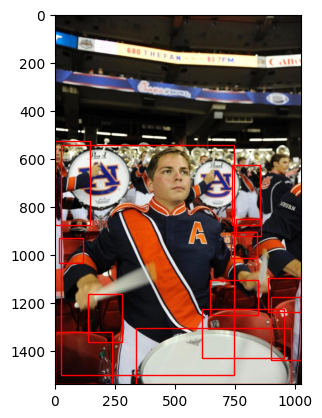

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch for each bounding box and add it to the axes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [21]:
from PIL import Image
import torch
from transformers import YolosForObjectDetection, YolosImageProcessor
import numpy as np
import cv2

IMG_HEIGHT, IMG_WIDTH = 256, 256

# Fonction pour charger les modèles (à adapter selon vos chemins et configurations)
def load_models():
    object_detection_model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
    image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
    # Assurez-vous que le modèle U-Net est correctement chargé ici
    unet_model = FaceModel(in_channels=3, out_classes=1)
    unet_model.load_state_dict(torch.load('unet_model_small_v2.pth', map_location=torch.device('cpu')))
    unet_model.eval()
    return object_detection_model, image_processor, unet_model

# Fonction pour générer et stocker les masques des ROI
def generate_roi_masks(image_path, object_detection_model, image_processor, unet_model):
    masks_list = []
    boxes_list = []
    image = Image.open(image_path)
    image = image.convert('RGB')

    # Détection des objets avec YOLOS
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = object_detection_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
    class_names = object_detection_model.config.id2label

    for box, label in zip(results['boxes'], results['labels']):
      if class_names[label.item()] == 'person':
        xmin, ymin, xmax, ymax = box.detach().numpy().tolist()
        roi = image.crop((xmin, ymin, xmax, ymax))

        # Convertir PIL Image en Tensor PyTorch pour U-Net
        transform = T.Compose([
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Resize((IMG_HEIGHT, IMG_WIDTH), antialias=True)
            ])
        roi_tensor = transform(roi).unsqueeze(0)  # Ajouter une dimension de batch

        # Prédiction du masque avec U-Net
        with torch.no_grad():
            mask_pred = unet_model(roi_tensor)
        mask_pred = mask_pred.squeeze().cpu().numpy()  # Enlever la dimension de batch et convertir en numpy
        mask_pred = (mask_pred > 0.5).astype(np.uint8)  # Seuillage pour obtenir un masque binaire

        # Stocker le masque et les coordonnées de la bounding box
        masks_list.append(mask_pred)
        boxes_list.append((xmin, ymin, xmax, ymax))

    return masks_list, boxes_list

# Chargement des modèles
object_detection_model, image_processor, unet_model = load_models()

In [33]:
image_path = "/content/data/images/59--People-Driving-Car/59_peopledrivingcar_peopledrivingcar_59_1014.jpg"

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

def display_image_with_masks_only(image_path, masks_list, boxes_list):
    # Charger l'image originale
    image = Image.open(image_path)
    image_np = np.array(image.convert('RGB'))

    # Créer une figure pour l'affichage
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image_np)

    # Générer une couleur unique pour chaque masque
    colors = np.random.randint(0, 255, size=(len(masks_list), 3))

    for mask, (xmin, ymin, xmax, ymax), color in zip(masks_list, boxes_list, colors):
        # Ajuster les coordonnées pour qu'elles soient entières
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

        # Redimensionner le masque pour correspondre à la bounding box
        mask_resized = cv2.resize(mask, (xmax-xmin, ymax-ymin))
        mask_colored = np.zeros((ymax-ymin, xmax-xmin, 3), dtype=np.uint8)

        # Appliquer la couleur unique au masque
        mask_colored[mask_resized > 0] = color

        # Convertir le masque coloré en image PIL pour le superposer
        overlay_mask = Image.fromarray(mask_colored, 'RGB')
        overlay_image = Image.fromarray(image_np[ymin:ymax, xmin:xmax])

        # Assurer que le masque et l'image ont la même taille avant la fusion
        if overlay_image.size != overlay_mask.size:
            overlay_mask = overlay_mask.resize(overlay_image.size, Image.ANTIALIAS)

        # Fusionner l'image et le masque uniquement là où le masque est présent
        overlay_image_np = np.array(overlay_image)
        overlay_image_np[mask_resized > 0] = np.array(overlay_mask)[mask_resized > 0]
        blended = Image.fromarray(overlay_image_np)

        # Mélanger l'image originale et le masque avec une transparence de 0.5
        image_np[ymin:ymax, xmin:xmax] = np.array(Image.blend(Image.fromarray(image_np[ymin:ymax, xmin:xmax]), blended, alpha=0.7))

    # Mettre à jour le plot avec l'image superposée
    ax.imshow(image_np)
    plt.axis('off')
    plt.show()

def display_image_with_masks_and_bboxes(image_path, masks_list, boxes_list):
    # Charger l'image originale
    image = Image.open(image_path)
    image_np = np.array(image.convert('RGB'))

    # Créer une figure pour l'affichage
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image_np)

    # Générer une couleur unique pour chaque masque
    colors = np.random.randint(0, 255, size=(len(masks_list), 3))

    for mask, (xmin, ymin, xmax, ymax), color in zip(masks_list, boxes_list, colors):
        # Ajuster les coordonnées pour qu'elles soient entières
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

        # Dessiner la bounding box autour de l'objet détecté
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Redimensionner le masque pour correspondre à la bounding box
        mask_resized = cv2.resize(mask, (xmax-xmin, ymax-ymin))
        mask_colored = np.zeros((ymax-ymin, xmax-xmin, 3), dtype=np.uint8)

        # Appliquer la couleur unique au masque
        mask_colored[mask_resized > 0] = color

        # Convertir le masque coloré en image PIL pour le superposer
        overlay_mask = Image.fromarray(mask_colored, 'RGB')
        overlay_image = Image.fromarray(image_np[ymin:ymax, xmin:xmax])

        # Assurer que le masque et l'image ont la même taille avant la fusion
        if overlay_image.size != overlay_mask.size:
            overlay_mask = overlay_mask.resize(overlay_image.size, Image.ANTIALIAS)

        # Fusionner l'image et le masque uniquement là où le masque est présent
        overlay_image_np = np.array(overlay_image)
        overlay_image_np[mask_resized > 0] = np.array(overlay_mask)[mask_resized > 0]
        blended = Image.fromarray(overlay_image_np)

        # Mélanger l'image originale et le masque avec une transparence de 0.5
        image_np[ymin:ymax, xmin:xmax] = np.array(Image.blend(Image.fromarray(image_np[ymin:ymax, xmin:xmax]), blended, alpha=0.7))

    # Mettre à jour le plot avec l'image superposée
    ax.imshow(image_np)
    plt.axis('off')
    plt.show()

In [35]:
masks_list, boxes_list = generate_roi_masks(image_path, object_detection_model, image_processor, unet_model)

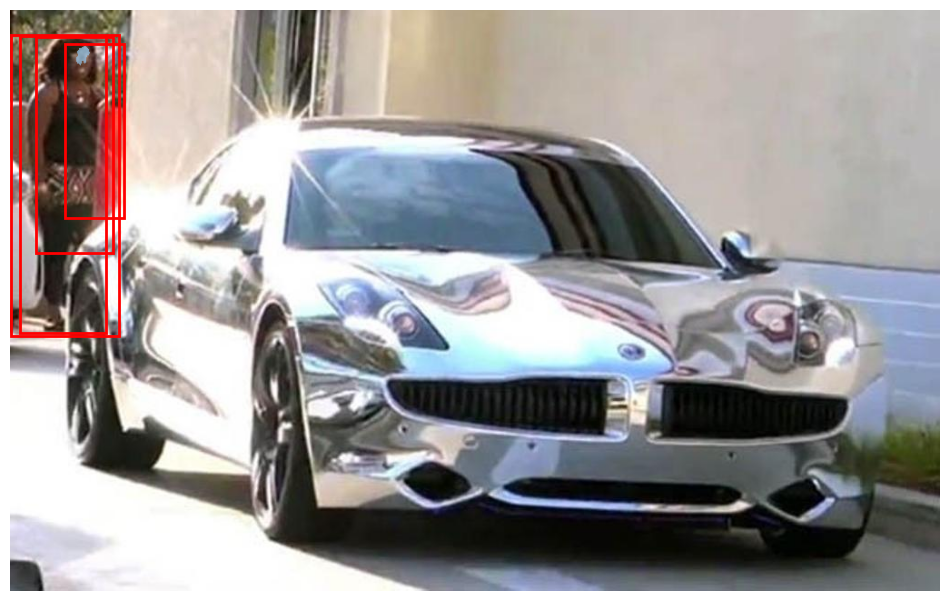

In [36]:
display_image_with_masks_and_bboxes(image_path, masks_list, boxes_list)

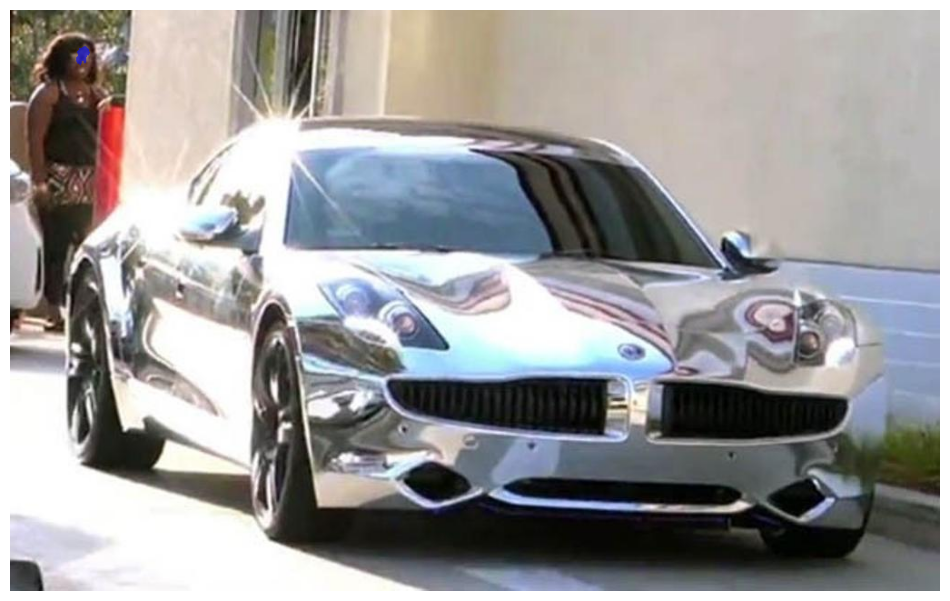

In [37]:
display_image_with_masks_only(image_path, masks_list, boxes_list)